# Fine-tune  a small LLM with TRL and Transformers

why fine-tune?

- Adapt a pre-trained model to a specific task or domain
- Improve performance on specialized datasets
- Reduce the need for large amounts of labeled data
- Customize model behavior to meet specific requirements

## how to fine-tune an LLM model

we are going to do Supervised Fine-Tuning (SFT) using the `trl` library along with `transformers`.

Basically SFT = give samples of inputs and outputs.

For example if our goal was to extract names:
- Input: Hello my name is Daniel
- Output: Daniel

## What we're going to build
We are going to fine-tune a small LLM to extract food items from text.

Why?
If we needed to go over a large dataset of image captions and filter them for food items (we could then use these filtered captions for a food app).

## Ingredients

1. Model (gemma3-270M)
2. Dataset (a pre-baked dataset to extract foods from text)
3. Training code
4. Eval code
5. Demo

## Method
1. Download model - Hugging Face 'transformers'
2. Download dataset - Hugging Face
3. Inspect dataset - Hugging Face "datasets
4. Train model on dataset - Hugging Face
5. Eval model - basically just look at a bunch of samples
6. Create an interactive demo - Hugging Face "gradio'
7. Bonus: Make the demo public so other people can use it - "Hugging Face Spaces"

## Fine-Tunening LLM vs RAG

* Fine-tuning = To do a very specific task, e.g. structured data extraction.
    * An example would be you're an insurance company who gets 10,000 emails a day and you want to extract structured data directly from these emails to JSON.
* RAG = You want to inject custom knowledge into an LLM.
    * An example would be you're an insurance company wanting to send *automatic* responses to people but you want the responses to include information from your own docs.markdown




In [1]:
import transformers
import trl
import datasets

# Model

In [2]:
MODEL_NAME = 'google/gemma-3-270m-it'

In [3]:
import torch

print(f'pytorch version: {torch.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

pytorch version: 2.9.1
Using device: cpu


In [ ]:
from huggingface_hub import login
import os
# You will be prompted to enter your Hugging Face token
# Token'ı doğrudan koda yazma. Colab Secrets / env ile ver.
os.environ["HF_TOKEN"] = ""  

login(token=os.environ["HF_TOKEN"])


In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype='auto',
    device_map='auto', # put the model on the GPU
    attn_implementation='eager' # could use flash_attention_2 but ran into issues
)

In [6]:
model

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((640,), eps=1e-06)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'[INFO] model on device: {device}')
print(f'[INFO] model dtype: {model.dtype}')

[INFO] model on device: cpu
[INFO] model dtype: torch.bfloat16


In [8]:
tokenizer('Hello, my na me is berker')

{'input_ids': [2, 9259, 236764, 1041, 1784, 786, 563, 3690, 5806], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
outputs = model(torch.tensor(tokenizer('Hello, my na me is berker')['input_ids']).unsqueeze(0).to('mps')) # you can use device
outputs

CausalLMOutputWithPast(loss=None, logits=tensor([[[ -8.1250,  -0.2539,  -1.5469,  ...,  -8.9375,  -8.9375,  -8.8750],
         [-20.3750,  -7.1562,  -6.6875,  ..., -20.3750, -20.3750, -20.3750],
         [-11.5000,   0.5508,  -3.3438,  ..., -10.3750, -10.3125, -10.3750],
         ...,
         [ -9.5625,   2.2656,  -3.9375,  ...,  -8.6875,  -8.6875,  -8.6875],
         [ -7.2812,   6.0312,  -2.3125,  ...,  -7.6562,  -7.5938,  -7.6562],
         [ -9.3125,   5.5000,  -4.8750,  ...,  -9.1250,  -9.1250,  -9.1250]]],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<LinearBackward0>), past_key_values=DynamicCache(layers=[DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindo

In [11]:
outputs.keys()

odict_keys(['logits', 'past_key_values'])

### Get dataset

In [12]:
from datasets import load_dataset

dataset = load_dataset('mrdbourke/FoodExtract-1k')
print(f'[INFO] Number of samples in the dataset: {len(dataset["train"])}')

[INFO] Number of samples in the dataset: 1420


In [14]:
import random

def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in a dataset."""
    random_idx = random.randint(0, len(dataset) - 1)
    return random_idx


random_idx = get_random_idx(dataset['train'])
random_sample = dataset['train'][random_idx]

print(f'[INFO] Random index: {random_idx}')
random_sample

[INFO] Random index: 348


{'sequence': 'orange flower water in a bottle',
 'image_url': 'https://smokeysombrero.com/wp-content/uploads/2016/10/wp-1477541525949-e1477762286576-768x1024.jpg',
 'class_label': 'food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 31.0,
 'word_count': 6.0,
 'syn_or_real': 'real',
 'uuid': '1b9634a2-6b15-4627-81c1-ab91e93b41b3',
 'gpt-oss-120b-label': "{'is_food_or_drink': True, 'tags': ['di'], 'food_items': [], 'drink_items': ['orange flower water']}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 1\ntags: di\nfoods: \ndrinks: orange flower water',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None}

In [15]:
import json

example_input = random_sample['sequence']
example_output = random_sample['gpt-oss-120b-label']
example_output_condensed = random_sample['gpt-oss-120b-label-condensed']

print(f'[INFO] Input:\n{example_input}')
print('-----------------------------------')
print(f'[INFO] Output:')
print(eval(example_output))
print('-----------------------------------')
print(f'[INFO] Condensed Output:')
print(example_output_condensed)


[INFO] Input:
orange flower water in a bottle
-----------------------------------
[INFO] Output:
{'is_food_or_drink': True, 'tags': ['di'], 'food_items': [], 'drink_items': ['orange flower water']}
-----------------------------------
[INFO] Condensed Output:
food_or_drink: 1
tags: di
foods: 
drinks: orange flower water


### Format the dataset into LLM-style inputs and outputs

Right now we have examples of string-based inputs and structured outputs.

However, our LLMs generally want things in the format of:

```
{"user":
"Hello my name is Berker",
"system": "Hi Berker, I'm an LLM"}
```

In other words, they want structure around the intputs and outputs rather than just raw information.

**Resource:** See the dataset formats and types in the TRL docs: https://huggingface.co/docs/trl/en/dataset_formats

In [16]:
random_sample

{'sequence': 'orange flower water in a bottle',
 'image_url': 'https://smokeysombrero.com/wp-content/uploads/2016/10/wp-1477541525949-e1477762286576-768x1024.jpg',
 'class_label': 'food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 31.0,
 'word_count': 6.0,
 'syn_or_real': 'real',
 'uuid': '1b9634a2-6b15-4627-81c1-ab91e93b41b3',
 'gpt-oss-120b-label': "{'is_food_or_drink': True, 'tags': ['di'], 'food_items': [], 'drink_items': ['orange flower water']}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 1\ntags: di\nfoods: \ndrinks: orange flower water',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None}

In [17]:
def sample_to_conversation(sample):
    return{
        'messages': [
            {'role': 'user', 'content': sample['sequence']},
            {'role': 'assistant', 'content': sample['gpt-oss-120b-label']}
        ]
    }

conversation_sample = sample_to_conversation(random_sample)
conversation_sample

{'messages': [{'role': 'user', 'content': 'orange flower water in a bottle'},
  {'role': 'assistant',
   'content': "{'is_food_or_drink': True, 'tags': ['di'], 'food_items': [], 'drink_items': ['orange flower water']}"}]}

In [18]:
# map our sample_to_conversation function to dataset
dataset = dataset.map(sample_to_conversation,
                      batched=False)
dataset['train'][0]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

In [19]:
# create a train/test split
dataset = dataset['train'].train_test_split(test_size=0.2,
                                             seed=42,
                                             shuffle=False)

# always train on the train set and test on the test set
# This gives us an indication of how well  the model has learned the
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

In [20]:
dataset['train'][0]['messages']

[{'content': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

### Try the model with a pipeline

In [24]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
    )

Device set to use mps


In [25]:
easy_sample = {'role': 'user', 'content': 'bana makine öğrenmesi ile ilglili şiir yaz'},

def create_easy_sample(input):
    tamplate = {'role': 'user', 'content': input}
    return tamplate

In [26]:
input_text = 'Hi my name is Berker, write a poem about machine learning'

easy_sample = create_easy_sample(input_text)

input_prompt = pipe.tokenizer.apply_chat_template([easy_sample],
                                                  tokenize=False,
                                                  add_generation_prompt=True)
print(f'[INFO] Input prompt:\n{input_prompt}')

default_outputs = pipe(input_prompt,
                       max_new_tokens=256,
                       disable_compile=True)
default_outputs

[INFO] Input prompt:
<bos><start_of_turn>user
Hi my name is Berker, write a poem about machine learning<end_of_turn>
<start_of_turn>model



[{'generated_text': '<bos><start_of_turn>user\nHi my name is Berker, write a poem about machine learning<end_of_turn>\n<start_of_turn>model\n'}]

In [27]:
print(f'[INFO] Input prompt:\n{input_text}')
print('-----------------------------------')
print(f'[INFO] Model name: {MODEL_NAME}')
print('-----------------------------------')
print(default_outputs[0]['generated_text'][len(input_prompt):])

[INFO] Input prompt:
Hi my name is Berker, write a poem about machine learning
-----------------------------------
[INFO] Model name: google/gemma-3-270m-it
-----------------------------------



### Try the model on one of our sequences from the dataset

In [28]:
random_sample

{'sequence': 'orange flower water in a bottle',
 'image_url': 'https://smokeysombrero.com/wp-content/uploads/2016/10/wp-1477541525949-e1477762286576-768x1024.jpg',
 'class_label': 'food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 31.0,
 'word_count': 6.0,
 'syn_or_real': 'real',
 'uuid': '1b9634a2-6b15-4627-81c1-ab91e93b41b3',
 'gpt-oss-120b-label': "{'is_food_or_drink': True, 'tags': ['di'], 'food_items': [], 'drink_items': ['orange flower water']}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 1\ntags: di\nfoods: \ndrinks: orange flower water',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None}

In [29]:
# get a random training sample
random_idx = get_random_idx(dataset['train'])
random_train_sample = dataset['train'][random_idx]

# apply the chat template to the sample

input_promt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample['messages'][:1],
                                                 tokenize=False,
                                                 add_generation_prompt=True)
# let's run the default model on our input
default_outputs = pipe(input_promt,
                       max_new_tokens=256,
                       disable_compile=True)

#  viiew anad compare the outputs
print(f'[INFO] Input prompt:\n{input_promt}')
print('-----------------------------------')
print(f'[INFO] Model name: {MODEL_NAME}')
print('-----------------------------------')
print(default_outputs[0]['generated_text'][len(input_promt):])

[INFO] Input prompt:
<bos><start_of_turn>user
**Detailed Descriptive Caption:**

The image depicts a detailed stock analysis interface against a black background, possibly sourced from a financial platform like Yahoo Finance or TradingView. The focal stock is Celsius Holdings Inc. (CELH), currently trading at $152.35. On this particular day, the stock price increased by $4.48, which translates to a gain of 3.03%. 

Two actionable buttons are visible: one for CEL trading at $152.30 and a buy button priced at $152.44. The existing bid size is two, while the ask size stands at one. Navigational tabs include options for "Chart," "News," "Options," and "Level 2," with the current focus set to "Chart."

The chart below visualizes stock performance data ranging from March through June. Notably, the stock price escalated from approximately $80 in March to roughly $90 in April and surpassed $100 in May. By mid-June, the stock peaked near $153, reaching a high of $153.4599. The chart employs red

### Let's try to prompt the model

We want a model to extract food and drink items from text.

By default the model will just reply to any text input.

However, we can try and get our ideal outputs via prompting.



In [30]:
prompt_instructions = """"Given the following target input text from an image caption, please extract the food and drink items to
a  list. If there are no food or drink items, return an empty list.

Retun in the fallowing format:
food_items = [item_1, item_2, item_3]
drink_items = [item_1, item_2, item_3]

for example:
Input text = Hello my name is Berker.
Output:
food_items = []
drink_items = []

example 2:
Input text = I had a sandwich and a coffee for lunch.
Output:
food_items = ['sandwich']
drink_items = ['coffee']

target input text: <targ_input_text>

"""

def update_input_message_prompt(input):
    original_content = input['messages'][:1][0]['content']
    new_content = prompt_instructions.replace('<targ_input_text>', original_content)

    new_input = [{'content': new_content,
                  'role': 'user'}]
    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print('[INFO] Updated prompt content:')
print(update_input_message_prompt(input=random_train_sample)[:1][0]['content'])


[INFO] Original content:
**Detailed Descriptive Caption:**

The image depicts a detailed stock analysis interface against a black background, possibly sourced from a financial platform like Yahoo Finance or TradingView. The focal stock is Celsius Holdings Inc. (CELH), currently trading at $152.35. On this particular day, the stock price increased by $4.48, which translates to a gain of 3.03%. 

Two actionable buttons are visible: one for CEL trading at $152.30 and a buy button priced at $152.44. The existing bid size is two, while the ask size stands at one. Navigational tabs include options for "Chart," "News," "Options," and "Level 2," with the current focus set to "Chart."

The chart below visualizes stock performance data ranging from March through June. Notably, the stock price escalated from approximately $80 in March to roughly $90 in April and surpassed $100 in May. By mid-June, the stock peaked near $153, reaching a high of $153.4599. The chart employs red and green candlestic

In [31]:
# apply the chat template to the sample

updated_input_promt = update_input_message_prompt(input=random_train_sample)

input_promt = pipe.tokenizer.apply_chat_template(conversation=updated_input_promt,
                                                 tokenize=False,
                                                 add_generation_prompt=True)
# let's run the default model on our input
default_outputs = pipe(input_promt,
                       max_new_tokens=256,
                       disable_compile=True)

#  viiew anad compare the outputs
print(f'[INFO] Input prompt:\n{input_promt}')
print('-----------------------------------')
print(f'[INFO] Model name: {MODEL_NAME}')
print('-----------------------------------')
print(default_outputs[0]['generated_text'][len(input_promt):])

[INFO] Input prompt:
<bos><start_of_turn>user
"Given the following target input text from an image caption, please extract the food and drink items to
a  list. If there are no food or drink items, return an empty list.

Retun in the fallowing format:
food_items = [item_1, item_2, item_3]
drink_items = [item_1, item_2, item_3]

for example:
Input text = Hello my name is Berker.
Output:
food_items = []
drink_items = []

example 2:
Input text = I had a sandwich and a coffee for lunch.
Output:
food_items = ['sandwich']
drink_items = ['coffee']

target input text: **Detailed Descriptive Caption:**

The image depicts a detailed stock analysis interface against a black background, possibly sourced from a financial platform like Yahoo Finance or TradingView. The focal stock is Celsius Holdings Inc. (CELH), currently trading at $152.35. On this particular day, the stock price increased by $4.48, which translates to a gain of 3.03%. 

Two actionable buttons are visible: one for CEL trading at $1

In [32]:
# this is a input
print(random_train_sample['messages'][0]['content'])
print()
# this is are ideal output
print(random_train_sample['messages'][1]['content'])

**Detailed Descriptive Caption:**

The image depicts a detailed stock analysis interface against a black background, possibly sourced from a financial platform like Yahoo Finance or TradingView. The focal stock is Celsius Holdings Inc. (CELH), currently trading at $152.35. On this particular day, the stock price increased by $4.48, which translates to a gain of 3.03%. 

Two actionable buttons are visible: one for CEL trading at $152.30 and a buy button priced at $152.44. The existing bid size is two, while the ask size stands at one. Navigational tabs include options for "Chart," "News," "Options," and "Level 2," with the current focus set to "Chart."

The chart below visualizes stock performance data ranging from March through June. Notably, the stock price escalated from approximately $80 in March to roughly $90 in April and surpassed $100 in May. By mid-June, the stock peaked near $153, reaching a high of $153.4599. The chart employs red and green candlesticks to illustrate price fl

Okay looks like our small LLM doesn't do what we want it to do... no matter, we can fine-tune it so it does our specific task!

## Fine-tuning our model

Steps:

1. Setup SFTConfig (Supervised Fine-Tuning Config) - https://huggingface.co/docs/trl/sft_trainer
2. Use STrainer to train our model on our supervised samples - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer

In [33]:
# setting up our SFTConfig
from trl import SFTConfig

torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = './checkpoint_models'
BASE_LEARNING_RATE = 5e-5

print(f'[INFO] Using dtype: {torch_dtype}')
print(f'[INFO] Using learning rate: {BASE_LEARNING_RATE}')


sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_checkpointing=False,
    optim='adamw_torch_fused',
    logging_steps=1,
    save_strategy='epoch',
    eval_strategy='epoch',
    learning_rate=BASE_LEARNING_RATE,
    fp16=True if torch_dtype==torch.float16 else False,
    bf16=True if torch_dtype==torch.bfloat16 else False,
    lr_scheduler_type='constant',
    push_to_hub=False,
    report_to=None
)

sft_config

[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


SFTConfig(output_dir='./checkpoint_models', overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, eval_strategy=<IntervalStrategy.EPOCH: 'epoch'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3, max_steps=-1, lr_scheduler_type=<SchedulerType.CONSTANT: 'constant'>, lr_scheduler_kwargs=None, warmup_ratio=0.0, warmup_steps=0, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='./checkpoint_models/runs/Feb02_23-03-27_192.168.1.2', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=1, logging_nan_inf_filter=True, save_strategy=<SaveStrategy.EPOCH: 'epoch'>, save_

In [34]:
from trl import SFTTrainer

# create Trainer object
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
    args=sft_config,
)

trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.
/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 16.75 GiB, other allocations: 1.01 GiB, max allowed: 20.13 GiB). Tried to allocate 2.88 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

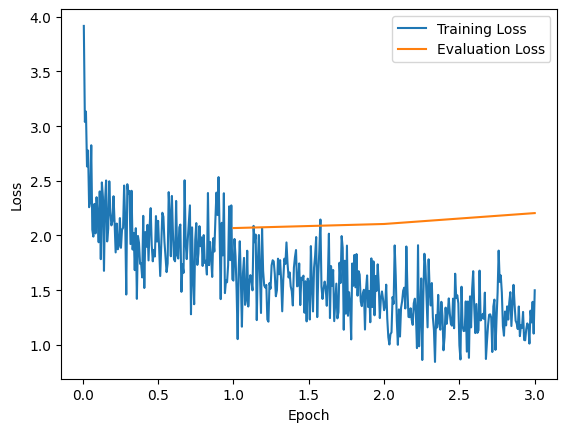

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
epoch_train = [log['epoch'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epoch_eval = [log['epoch'] for log in log_history if 'eval_loss' in log]

#plot the training loss
plt.plot(epoch_train, train_loss, label='Training Loss')
plt.plot(epoch_eval, eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tags_dict = {'np': 'nutrition_panel',
'il': 'ingredient list',
'me': 'menu',
're': 'recipe',
'fi': 'food_items',
'di': 'drink_items',
'fa': 'food_advertistment',
'fp': 'food_packaging'
}

In [ ]:
trainer.save_model()

## Load the trained model back in and see how it performs

We've now fine-tuned our own Gemma 3 270M to do a specific task, let's load it back in and see how it performs.

In [1]:
CHECKPOINT_DIR_NAME = "/Users/berkeruveyik/pythonDersleri/finetune-llm/checkpoint_models/checkpoint-426"

In [2]:
# load the fine-tuned model and see how it goes
from transformers import AutoModelForCausalLM, AutoTokenizer

loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=CHECKPOINT_DIR_NAME,
    device_map='auto',
    dtype='auto',
    attn_implementation='eager'
)

loaded_model

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((640,), eps=1e-06)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_DIR_NAME)

The tokenizer you are loading from '/Users/berkeruveyik/pythonDersleri/finetune-llm/checkpoint_models/checkpoint-426' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [7]:
from transformers import pipeline, AutoTokenizer

loaded_model_pipeline = pipeline(
    "text-generation",
    model=loaded_model,
    tokenizer=tokenizer
)

Device set to use mps


In [22]:
# get a random training sample
random_test_idx = get_random_idx(dataset['test'])
random_test_sample = dataset['test'][random_test_idx]

# apply the chat template to the sample

input_promt = loaded_model_pipeline.tokenizer.apply_chat_template(conversation=random_test_sample['messages'][:1],
                                                 tokenize=False,
                                                 add_generation_prompt=True)
# let's run the default model on our input
default_outputs = loaded_model_pipeline(input_promt,
                       max_new_tokens=256,
                       disable_compile=True)

#  viiew anad compare the outputs
print(f'[INFO] Input prompt:\n{input_promt}')
print('-----------------------------------')
print(f'[INFO] Model name: {MODEL_NAME}')
print('-----------------------------------')
print(default_outputs[0]['generated_text'][len(input_promt):])

[INFO] Input prompt:
<bos><start_of_turn>user
A jar of Vegemite with a yellow lid and label. The label states "Made in Australia from at least 95% Australian ingredients." Ingredients include yeast extract (wheat, barley), natural color (150a), humectant (422), mineral salt (508), salt, malt extract (barley), flavors, niacin, thiamine, vitamin B6, riboflavin, folate, and vitamin B12. Contains wheat and gluten. Nutrition information per serving: energy 39 kJ, protein 1.1g, fat total <1g, saturated <1g, carbohydrate <1g, sugars 0.4g, dietary fiber 0.9g, sodium 165mg, potassium 0.55mg, thiamine (B1) 0.25mg, riboflavin (B2) 1.00mg, niacin (B3) 0.4mg, folate (B9) 0.5mg, vitamin B6 0.04mg, vitamin B12 0.05mg. Suitable for vegetarians and vegans. No artificial colors and flavors. Store in a cool, dry place. 40% less sodium (and salt) when compared to original. Brand: Vegemite, Bega Cheese Limited, Port Melbourne, Victoria, Australia.<end_of_turn>
<start_of_turn>model

------------------------

In [25]:
print(random_test_sample['gpt-oss-120b-label-condensed'])

food_or_drink: 1
tags: np, il, fi, fp
foods: Vegemite, yeast extract, wheat, barley, malt extract, salt
drinks:


In [26]:
dataset['train']

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 1136
})

In [27]:
# eval on these
dataset['test']

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 284
})

In [28]:
def get_model_num_params(model):
    """Returns the number of trainable, non-trainable and total parameters of a PyTorch model."""
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {
        "trainable_params": trainable_params,
        "non_trainable_params": non_trainable_params,
        "total_params": total_params
    }

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176
